<h1 style="text-align: center;">
    Assignment 2: Image Classification
</h1>
<div style="text-align: right;"> <b>
    Name: Pronoy Patra <br>
    Roll No.: 2021112019
</div>


# Question 1:  Segmentation

## 1.1 Preparation
I copied the notebook from kaggle and changed number of eppochs to 1. I downloaded the dataset and put it in the same folder.

**Conext**

**Cityscapes data** contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

**Content**

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

**Dataset:**

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

**References:**

*   https://arxiv.org/pdf/1603.07285v1.pdf
*   https://towardsdatascience.com/u-net-b229b32b4a71



## 1.1 Preparation

### 1. Setup Libraries & device

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### 2. Configure data locations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/My Drive/Colab Notebooks/cityscapes_data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

Mounted at /content/drive
2975 500


### 3. Analyze data

/content/drive/My Drive/Colab Notebooks/cityscapes_data/train/365.jpg


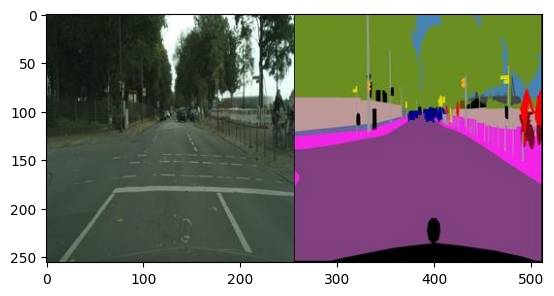

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

### 4. Extract Image and Labels

The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [ ]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

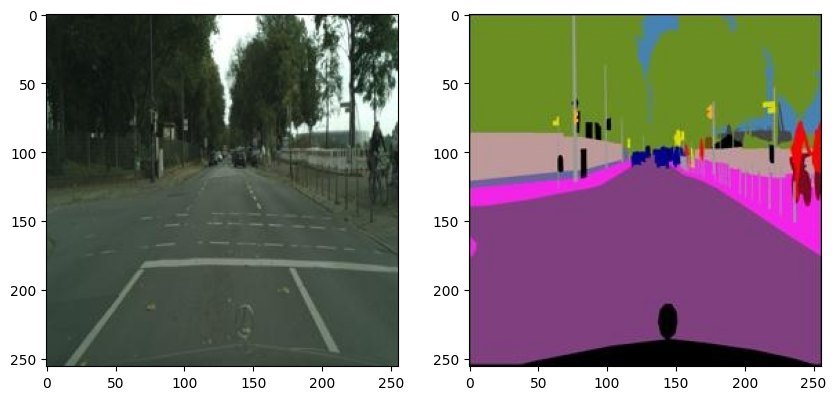

In [ ]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

### 5. Define Labels

We use K-means clustering to segregate the objects of different colors and assign them class labels.   

In [ ]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [ ]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

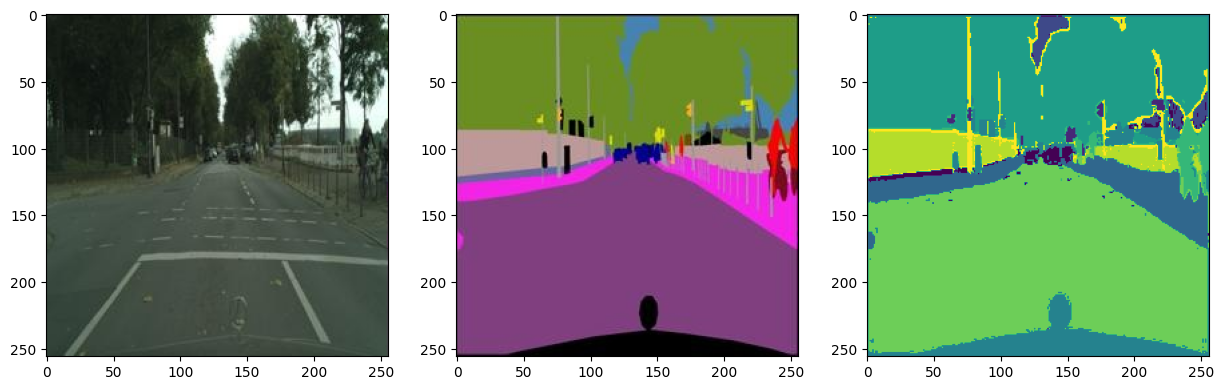

In [ ]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [ ]:
label_class

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 5, 9, ..., 5, 5, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=int32)

### 6. Define Dataset

In [ ]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [ ]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


### 7. Define Model


In [ ]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [ ]:
model = UNet(num_classes=num_classes)

In [ ]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744


AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [ ]:
Y_pred = model(X)
print(Y_pred.shape)

NameError: name 'X' is not defined

### 8. Train the model

In [ ]:
batch_size = 16

epochs = 1
lr = 0.01

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [ ]:
model = UNet(num_classes = num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

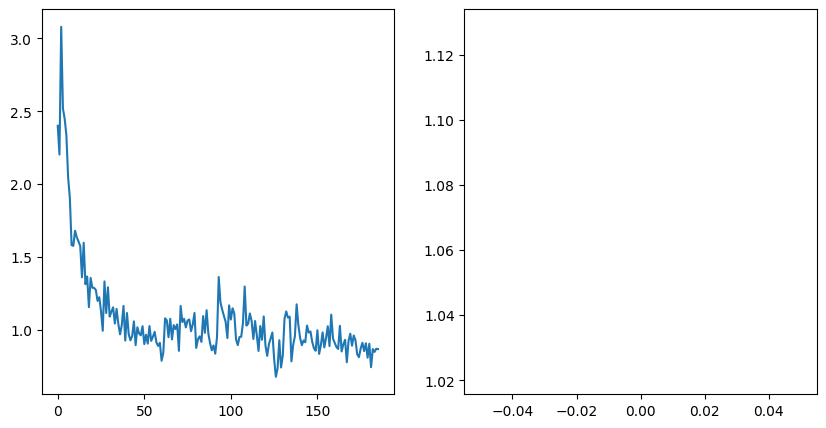

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

### 9. Check model predictions

In [ ]:
model_path = "./U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [ ]:
for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = model_(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    break

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [ ]:
iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)
iou_scores

[0.86875124172818,
 0.8435124216687343,
 0.9031347382061645,
 0.9522037823234273,
 0.8638890585863522,
 0.9313663785825032,
 0.8929443359375,
 0.930205487956295,
 0.8216857000993049,
 0.9276999340075814]

In [ ]:
print(sum(iou_scores) / len(iou_scores))

0.8935393079096041


## 1.2 Importance of skip connections

### Define Model Architecture without Skip Connections

In [ ]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=32)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=32, out_channels=64)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=512)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=32)
        self.output = nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(num_features=out_channels),
                            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(num_features=out_channels)
                            )
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 32, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 32, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 64, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 64, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 128, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 128, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 256, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 256, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 512, 16, 16]

        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 128, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 64, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 32, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes = 10, 256, 256]
        return output_out

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

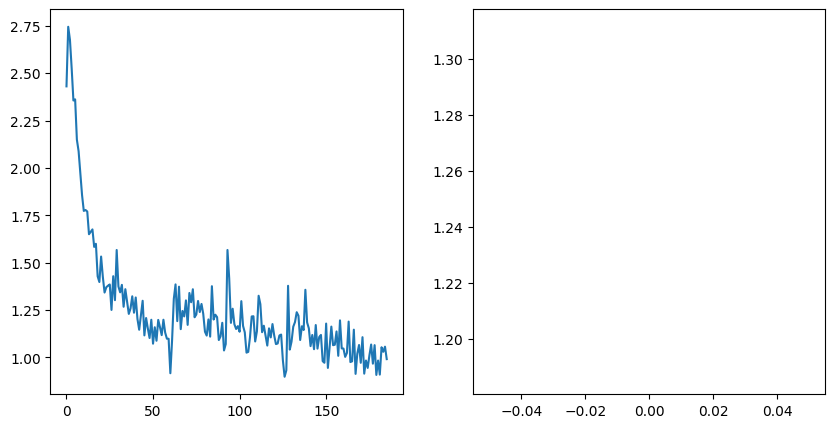

In [ ]:
batch_size = 16

epochs = 1
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)
model = UNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

model_name = "without-skip-connections-U-Net.pth"
torch.save(model.state_dict(), model_name)

In [ ]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

# print(dir(iter(data_loader)))
# X,Y = iter(data_loader)
for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = model(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    break


torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)
print(sum(iou_scores) / len(iou_scores))

iou_scores

0.8878367291271403


[0.9055262835436834,
 0.8316047818858364,
 0.9266180843360501,
 0.9424286180073594,
 0.8859010185227603,
 0.8826804441702653,
 0.8679656982421875,
 0.9173620249245298,
 0.8109922253868063,
 0.9072881122519242]

The slight drop in mIoU values can be observed from the removal of skip connections which lead to drop in the quality of reconstruction of images in the architecture.

## 1.3 Metrics for Computation

The challenge comes from binary nature of the current Intersection over Union (IoU) computation method. By treating both the ground truth and forecasted masks as binary entities, it might not adequately address the complexities of multi-class segmentation tasks.

This limitation becomes evident when employing architectures like U-Net for semantic segmentation, where pixels may pertain to multiple classes simultaneously.

Addressing this issue requires a shift in the approach to IoU computation. Instead of treating all classes uniformly, IoU must be computed independently for each class.

Subsequently, the mean IoU (mIoU) across all classes can be calculated to provide a comprehensive evaluation metric that accounts for the nuances of multi-class segmentation. This refined approach ensures a more accurate assessment of segmentation performance in scenarios involving complex class interactions.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

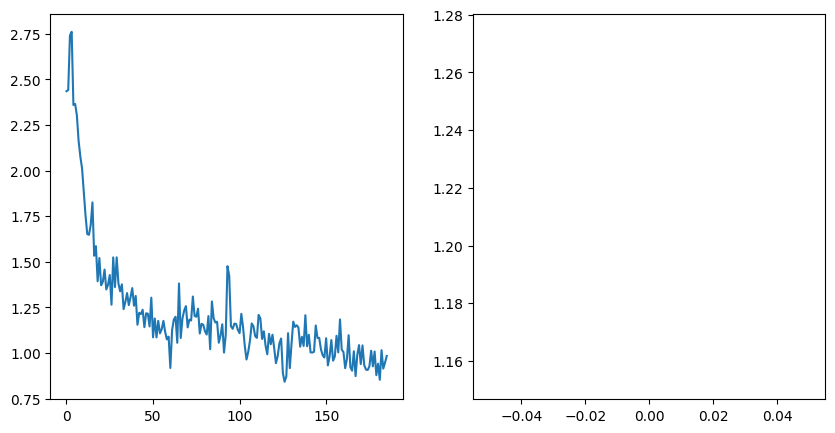

In [ ]:
batch_size = 16

epochs = 1
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)
model = UNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

model_name = "part4.pt"
torch.save(model.state_dict(), model_name)

In [ ]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

# print(dir(iter(data_loader)))
# X,Y = iter(data_loader)
for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = model(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    break

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

iou_scores = []
for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score for multiclass classification
    class_iou = []
    for j in range(num_classes):
        intersection = np.logical_and(label_class == j, label_class_predicted == j)
        union = np.logical_or(label_class == j, label_class_predicted == j)
        if (np.sum(union) == 0):
            continue
        iou = np.sum(intersection) / np.sum(union)
        class_iou.append(iou)
    mean_iou = np.mean(class_iou)
    iou_scores.append(mean_iou)
print(sum(iou_scores) / len(iou_scores))

iou_scores

0.1979313876641569


[0.13425273043861485,
 0.2321612329877948,
 0.2181458569605735,
 0.2563903722946749,
 0.20857602204267445,
 0.16422591152179383,
 0.15257348322352865,
 0.2186890557016566,
 0.2104196786009432,
 0.18387953286931463]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

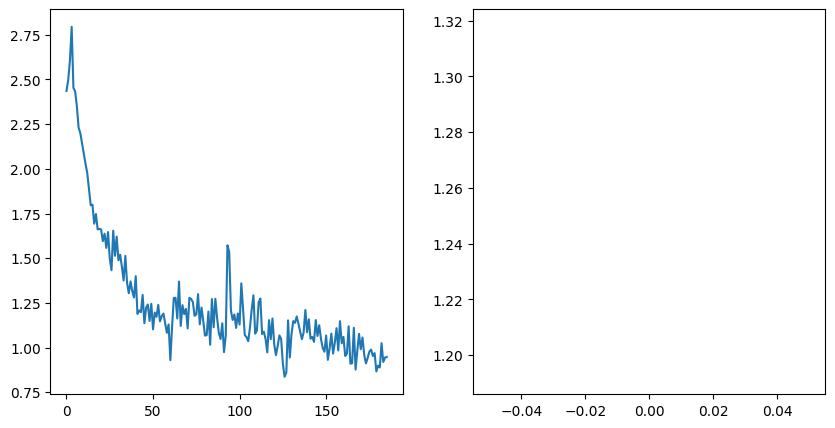

In [ ]:
batch_size = 16

epochs = 1
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)
model = UNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

model_name = "part4_without_skip.pt"
torch.save(model.state_dict(), model_name)

In [ ]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = model(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    break

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

iou_scores = []
for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score for multiclass classification
    class_iou = []
    for j in range(num_classes):
        intersection = np.logical_and(label_class == j, label_class_predicted == j)
        union = np.logical_or(label_class == j, label_class_predicted == j)
        if (np.sum(union) == 0):
            continue
        iou = np.sum(intersection) / np.sum(union)
        class_iou.append(iou)
    mean_iou = np.mean(class_iou)
    iou_scores.append(mean_iou)
print(sum(iou_scores) / len(iou_scores))

iou_scores

0.1986911075970475


[0.15323203219828782,
 0.22723368423147217,
 0.21453702738575187,
 0.23757827556275402,
 0.201798162337689,
 0.18582875326933312,
 0.17782073891641567,
 0.20027595846289986,
 0.21390699800534785,
 0.17469944560052328]

In this scenario, a notable drop in mean Intersection over Union (mIoU) values indicates a discernible change in model performance.

This decline is primarily attributed to the loss of skip connections, which compromise the quality of image reconstruction within the architecture.

The inclusion of skip connections plays a pivotal role in several aspects of semantic segmentation:

1. **Preservation of Spatial Information:**
Skip connections facilitate the integration of fine-grained details with higher-level features, enhancing the accuracy of segmentation by preserving spatial information effectively.
2. **Enhancement of Contextual Understanding:**
Skip connections contribute to the amalgamation of multi-resolution features, enriching the model's contextual understanding. This contextual information is crucial for accurately assigning class labels to individual pixels, especially in scenarios requiring global context comprehension.
The stark contrast in mIoU values underscores the significance of skip connections in multi-class segmentation tasks, highlighting their indispensable role in achieving superior segmentation accuracy and contextual understanding.
3. **Facilitation of Feature Reuse:**
By enabling the reuse of features learned at different hierarchical levels, skip connections empower the model to segment objects of diverse sizes and shapes. This feature reuse capability enhances the model's adaptability to complex data.


# Q2: Contrastive Language-Image Pretraining

## 2.1 Setup models

In [1]:
!pip3 install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-z05gzc4k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-z05gzc4k
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 899.4 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [2]:
import numpy as np
import torch
import torchvision
import torchsummary as summary
import clip
import cv2


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import ast

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/imagenet1000_classes.txt'
with open(file_path, 'r') as file:
    file_content = file.read()

# print(type(file_content))
classes_dict = ast.literal_eval(file_content)
print(classes_dict)

Mounted at /content/drive
{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma ma

In [5]:
model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2").to(device)
summary.summary(model, (3, 224, 224))

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [6]:
model1, preprocess = clip.load("RN50", device=device)
summary.summary(model1.visual, (3, 224, 224))

100%|████████████████████████████████████████| 244M/244M [00:02<00:00, 110MiB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          18,432
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
        AvgPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]           4,096
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

## 2.2. Setup data

(i) The label hierarchy used in ImageNet is based on WordNet, which is a large lexical database of English. WordNet organizes words into sets of synonyms called synsets, and it represents relationships between these synsets, such as hypernymy (is-a) and hyponymy (part-of).

(ii) A synset, short for "synonym set," is a group of words that are synonymous or semantically related. In the context of ImageNet, synsets are used to categorize objects into groups based on their semantic meanings. Each synset in ImageNet corresponds to a specific concept or object class.

(iii) Grouping objects based on synsets could potentially lead to problems for visual recognition because synsets may contain objects that share similar semantic meanings but have significantly different visual appearances. This could make it challenging for a computer vision system to accurately distinguish between objects within the same synset based solely on visual features.

(iv) Three types of visual differences we can expect to see in images with objects corresponding to the same synset include:

Variations in appearance: Objects within the same synset may have different colors, textures, sizes, or shapes. For example, within the synset for "dog," images may contain dogs of various breeds, each with distinct visual characteristics.

Different viewpoints or poses: Images of objects within the same synset may depict them from different angles or poses. For instance, within the synset for "chair," images may show chairs viewed from various perspectives, such as front-facing, side-view, or top-down.

Contextual variations: Objects within the same synset may appear in different contexts or environments, leading to variations in background, lighting conditions, and surrounding objects. For example, within the synset for "car," images may show cars parked on streets, highways, or in garages, each with different contextual cues.

## 2.3 Setup zero-shot CLIP

In [7]:
from PIL import Image

def probability_classes(image):
    image_np = cv2.imread(image)
    image = Image.fromarray(image_np.astype(np.uint8)).convert('RGB')  # Convert to RGB mode if necessary
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {classes_dict[c]}") for c in classes_dict]).to(device)

    with torch.no_grad():
        image_features = model1.encode_image(image_input)
        text_features = model1.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    print("\nTop predictions:\n")
    values_np = values.detach().cpu().numpy()
    indices_np = indices.detach().cpu().numpy()
    for value, index in zip(values_np, indices_np):
        print(f"{classes_dict[index]:>16s}: {100 * value.item():.2f}%")
    return

In [9]:
images = ['/content/drive/MyDrive/Colab Notebooks/tiger.jpeg', '/content/drive/MyDrive/Colab Notebooks/lion.jpeg', '/content/drive/MyDrive/Colab Notebooks/chair.jpeg', '/content/drive/MyDrive/Colab Notebooks/bird.jpeg', '/content/drive/MyDrive/Colab Notebooks/dog.jpeg']

for img in images:
  probability_classes(img)


Top predictions:

tiger, Panthera tigris: 80.08%
       tiger cat: 4.73%
jaguar, panther, Panthera onca, Felis onca: 4.59%
        Leonberg: 2.20%
           zebra: 2.07%

Top predictions:

borzoi, Russian wolfhound: 20.12%
timber wolf, grey wolf, gray wolf, Canis lupus: 13.83%
        Leonberg: 11.11%
 Irish wolfhound: 9.96%
white wolf, Arctic wolf, Canis lupus tundrarum: 8.79%

Top predictions:

    barber chair: 40.28%
   folding chair: 9.56%
          throne: 5.54%
             alp: 3.31%
          cradle: 3.31%

Top predictions:

indigo bunting, indigo finch, indigo bird, Passerina cyanea: 50.54%
             jay: 17.20%
          bulbul: 4.28%
ant, emmet, pismire: 1.99%
 junco, snowbird: 1.99%

Top predictions:

German shepherd, German shepherd dog, German police dog, alsatian: 93.90%
        malinois: 4.00%
Norwegian elkhound, elkhound: 0.44%
Doberman, Doberman pinscher: 0.22%
          kelpie: 0.19%


## 2.4 CLIP vs ImageNet pretraining.

CLIP's multimodal approach enables it to understand concepts beyond visual appearance. These images might contain textual descriptions or contextual cues that CLIP can leverage for accurate classification, whereas ImageNet pretrained ResNet50 relies solely on visual features.



In [10]:
import os

def list_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

directory_path = '/content/drive/MyDrive/Colab Notebooks/CLIP'
file_paths = list_files(directory_path)
print(file_paths)

# Clock 4: Resnet yes CLIP no
# beach 1: Renet no CLIP yes
# helicopter: Resnet yes clip no
#penguin1: resnet yes clip no
# cake 2: resnet yes clip no
# sunflower1: resnet no clip yes
# banana1: resnet ok clip no

# book
# cellphone
# apple

['/content/drive/MyDrive/Colab Notebooks/CLIP/hot_air_1.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/hot_air_2.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/hot_air_3.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/zebra_1.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/zebra_2.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/zebra_3.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/sushi_1.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/sushi_2.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/sushi_3.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/firework.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/firework_2.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/microscope_1.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/guitar.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/constellation.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/cupcake.jpeg', '/content/drive/MyDrive/Colab Notebooks/CLIP/waterfall.jpeg', '/content/drive/M

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Assuming you have already defined 'device'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
# model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2").to(device)
model.eval()  # Set the model to evaluation mode
# img = '/content/drive/MyDrive/Colab Notebooks/CLIP/hot_air_balloon.jpeg'
# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

images = file_paths
for img in images:
    input_image = Image.open(img)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_batch)

    _, predicted = torch.max(output, 1)

    predicted_label = classes_dict[predicted.item()]
    print("Predicted Label for ImageNet pretrained RN50:", predicted_label)

    print("Predictions for CLIP", end='')
    probability_classes(model1, img)


Predicted Label for ImageNet pretrained RN50: balloon
Predictions for CLIP
Top predictions:

parachute, chute: 93.74%
         balloon: 3.16%
airship, dirigible: 0.38%
            kite: 0.12%
            wing: 0.08%
Predicted Label for ImageNet pretrained RN50: balloon
Predictions for CLIP
Top predictions:

         gondola: 42.83%
parachute, chute: 16.77%
        tub, vat: 2.96%
      steel drum: 2.17%
       catamaran: 1.80%
Predicted Label for ImageNet pretrained RN50: balloon
Predictions for CLIP
Top predictions:

parachute, chute: 94.40%
         balloon: 3.84%
            kite: 0.38%
airship, dirigible: 0.20%
            wing: 0.11%
Predicted Label for ImageNet pretrained RN50: zebra
Predictions for CLIP
Top predictions:

           zebra: 95.29%
tiger, Panthera tigris: 1.06%
         gazelle: 0.77%
        Leonberg: 0.22%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 0.15%
Predicted Label for ImageNet pretrained RN50: zebra
Predictions for CLIP
Top pr

## 2.5 FP16

## Part 1: Convert the RN50 CLIP image encoder model to fp16.

In [11]:
clip_model, preprocess = clip.load("RN50", device=device)

for name, param in clip_model.named_parameters():
    precision = param.dtype
    print(f"Layer: {name}, precision: {precision}")

Layer: positional_embedding, precision: torch.float32
Layer: text_projection, precision: torch.float16
Layer: logit_scale, precision: torch.float32
Layer: visual.conv1.weight, precision: torch.float16
Layer: visual.bn1.weight, precision: torch.float32
Layer: visual.bn1.bias, precision: torch.float32
Layer: visual.conv2.weight, precision: torch.float16
Layer: visual.bn2.weight, precision: torch.float32
Layer: visual.bn2.bias, precision: torch.float32
Layer: visual.conv3.weight, precision: torch.float16
Layer: visual.bn3.weight, precision: torch.float32
Layer: visual.bn3.bias, precision: torch.float32
Layer: visual.layer1.0.conv1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.weight, precision: torch.float32
Layer: visual.layer1.0.bn1.bias, precision: torch.float32
Layer: visual.layer1.0.conv2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.weight, precision: torch.float32
Layer: visual.layer1.0.bn2.bias, precision: torch.float32
Layer: visual.layer1.0.conv3.weig

In [13]:
clip_model, preprocess = clip.load("RN50", device=device)

clip_model = clip_model.half()
clip_model = clip_model.to(device)

for name, param in clip_model.named_parameters():
    precision = param.dtype
    print(f"Layer: {name}, precision: {precision}")

Layer: positional_embedding, precision: torch.float16
Layer: text_projection, precision: torch.float16
Layer: logit_scale, precision: torch.float16
Layer: visual.conv1.weight, precision: torch.float16
Layer: visual.bn1.weight, precision: torch.float16
Layer: visual.bn1.bias, precision: torch.float16
Layer: visual.conv2.weight, precision: torch.float16
Layer: visual.bn2.weight, precision: torch.float16
Layer: visual.bn2.bias, precision: torch.float16
Layer: visual.conv3.weight, precision: torch.float16
Layer: visual.bn3.weight, precision: torch.float16
Layer: visual.bn3.bias, precision: torch.float16
Layer: visual.layer1.0.conv1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.bias, precision: torch.float16
Layer: visual.layer1.0.conv2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.bias, precision: torch.float16
Layer: visual.layer1.0.conv3.weig

We can observe that the original model has both layers simlutaneously. </br>
When we do half, then we have only the float16 dtype left.

In [18]:
from time import perf_counter
from PIL import Image

def encode_image(model, image):
    image_np = cv2.imread(image)
    image = Image.fromarray(image_np.astype(np.uint8)).convert('RGB')
    image_input = preprocess(image).unsqueeze(0).to(device)

    tokenized_texts = [clip.tokenize(f"a photo of a {classes_dict[c]}").to(device) for c in classes_dict]
    text_inputs = torch.cat(tokenized_texts)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    return image_features, text_features

def measure_inference_time(model, image, num_runs=100):
    times = []
    for _ in range(num_runs):
        start_time = perf_counter()
        encode_image(model, image)
        end_time = perf_counter()
        times.append(end_time - start_time)
    mean_time = sum(times) / len(times)
    std_dev = torch.std(torch.tensor(times))
    return mean_time, std_dev


def compute_class_probabilites(model, image):
    image_features, text_features = encode_image(model, image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).float().softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    print("\nTop predictions:\n")
    values_np = values.detach().cpu().numpy()
    indices_np = indices.detach().cpu().numpy()
    for value, index in zip(values_np, indices_np):
        print(f"{classes_dict[index]:>16s}: {100 * value.item():.2f}%")
    return

(wall-clock) time required to encode an
image

In [ ]:
avg_time_32=0
std_dev_32=0

for i in range(0,100):
    fp32_mean_time, fp32_std_dev = measure_inference_time(model1, '/content/drive/MyDrive/Colab Notebooks/tiger.jpeg')
    avg_time_32 += fp32_mean_time
    std_dev_32 += fp32_std_dev

print("Average time for encoding for FP32: ", avg_time_32)
print("Standard time for encoding for FP32: ", std_dev_32)

In [ ]:
avg_time_16=0
std_dev_16=0

for i in range(0,100):
    with torch.autocast(device_type=device,dtype=torch.float16):
        fp16_mean_time, fp16_std_dev = measure_inference_time(model1, '/content/drive/MyDrive/Colab Notebooks/tiger.jpeg')
        avg_time_16 += fp16_mean_time
        std_dev_16 += fp_16_mean_time

print("Average time for encoding for FP32: ", avg_time_16)
print("Standard time for encoding for FP32: ", std_dev_16)

## Part 2: For 5 images (1 per class), recalculate the probabilities using the fp16 model

In [28]:
images = ['/content/drive/MyDrive/Colab Notebooks/tiger.jpeg', '/content/drive/MyDrive/Colab Notebooks/lion.jpeg', '/content/drive/MyDrive/Colab Notebooks/apple.jpeg', '/content/drive/MyDrive/Colab Notebooks/bird.jpeg', '/content/drive/MyDrive/Colab Notebooks/dog.jpeg']

for img in images:
    compute_class_probabilites(model1, img)


def compute_class_probabilites_half(model, image):
    image_features, text_features = encode_image(model, image)
    image_features.half()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).float().softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    print("\nTop predictions:\n")
    values_np = values.detach().cpu().numpy()
    indices_np = indices.detach().cpu().numpy()
    for value, index in zip(values_np, indices_np):
        print(f"{classes_dict[index]:>16s}: {100 * value.item():.2f}%")
    return

for img in images:
    compute_class_probabilites_half(model1, img)


Top predictions:

tiger, Panthera tigris: 80.07%
       tiger cat: 4.73%
jaguar, panther, Panthera onca, Felis onca: 4.59%
        Leonberg: 2.20%
           zebra: 2.07%

Top predictions:

borzoi, Russian wolfhound: 20.12%
timber wolf, grey wolf, gray wolf, Canis lupus: 13.83%
        Leonberg: 11.11%
 Irish wolfhound: 9.96%
white wolf, Arctic wolf, Canis lupus tundrarum: 8.79%

Top predictions:

    Granny Smith: 40.06%
             fig: 13.21%
ballpoint, ballpoint pen, ballpen, Biro: 9.37%
         redbone: 6.64%
     bell pepper: 1.93%

Top predictions:

indigo bunting, indigo finch, indigo bird, Passerina cyanea: 50.55%
             jay: 17.20%
          bulbul: 4.28%
ant, emmet, pismire: 1.99%
 junco, snowbird: 1.99%

Top predictions:

German shepherd, German shepherd dog, German police dog, alsatian: 93.91%
        malinois: 4.00%
Norwegian elkhound, elkhound: 0.44%
Doberman, Doberman pinscher: 0.22%
          kelpie: 0.19%

Top predictions:

tiger, Panthera tigris: 80.07%
    

## Part 3:  Differences in memory usage for a forward pass

 While small CLIP models such as a ResNet-50 and ResNet-101 outperform other
ResNets trained on ImageNet-1K (BiT-S and the originals),
they underperform ResNets trained on ImageNet-21K (BiTM). These small CLIP models also underperform models
in the EfficientNet family with similar compute requirements. However, models trained with CLIP scale very well
and the largest model we trained (ResNet-50x64) slightly
outperforms the best performing existing model (a Noisy
Student EfficientNet-L2) on both overall score and compute
efficiency. We also find that CLIP vision transformers are
about 3x more compute efficient than CLIP ResNets, which
allows us to reach higher overall performance within our
compute budget.

In [22]:
import torch.cuda.amp as amp
image_path = '/content/drive/MyDrive/Colab Notebooks/tiger.jpeg'
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

clip_model, preprocess = clip.load("RN50", device=device)
clip_model = clip_model.to(device)

with amp.autocast(enabled=True):
    torch.cuda.memory._record_memory_history(enabled=None)
    start = torch.cuda.memory_summary()
    clip_model.encode_image(image)
    print(f"Memory usage with FP32 input: {torch.cuda.memory_allocated(device)} bytes")
    print('\n')
    end = torch.cuda.memory_summary()
    torch.cuda.memory._record_memory_history(enabled=None)
    print("Memory at start")
    print(start)
    print("Memory at end")
    print(end)

Memory usage with FP32 input: 1153089024 bytes


Memory at start
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1099 MiB |   2130 MiB |  76241 GiB |  76240 GiB |
|       from large pool |   1021 MiB |   2074 MiB |  76021 GiB |  76020 GiB |
|       from small pool |     77 MiB |     78 MiB |    220 GiB |    220 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1099 MiB |   2130 MiB |  76241 GiB |  76240 GiB |

In [23]:
import torch.cuda.amp as amp
image_path = '/content/drive/MyDrive/Colab Notebooks/tiger.jpeg'
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image = image.half()

clip_model, preprocess = clip.load("RN50", device=device)
clip_model = clip_model.half()
clip_model = clip_model.to(device)

with amp.autocast(enabled=True):
    torch.cuda.memory._record_memory_history(enabled=None)
    start = torch.cuda.memory_summary()
    clip_model.encode_image(image)
    print(f"Memory usage with FP16 input: {torch.cuda.memory_allocated(device)} bytes")
    print('\n')
    end = torch.cuda.memory_summary()
    torch.cuda.memory._record_memory_history(enabled=None)
    print("Memory summary at the start")
    print(start)
    print("Memory summary at the end")
    print(end)


Memory usage with FP16 input: 1100003840 bytes


Memory summary at the start
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1049 MiB |   2130 MiB |  76242 GiB |  76240 GiB |
|       from large pool |    971 MiB |   2074 MiB |  76021 GiB |  76020 GiB |
|       from small pool |     77 MiB |    112 MiB |    220 GiB |    220 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1049 MiB |   2130 MiB |  76242 GiB | 

In [24]:
import torchvision.models as models
import subprocess

img = '/content/drive/MyDrive/Colab Notebooks/tiger.jpeg'

import logging
import socket
from datetime import datetime, timedelta

import torch

from torch.autograd.profiler import record_function
from torchvision import models

logging.basicConfig(
   format="%(levelname)s:%(asctime)s %(message)s",
   level=logging.INFO,
   datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

def trace_handler(prof: torch.profiler.profile):
   # Prefix for file names.
   host_name = socket.gethostname()
   timestamp = datetime.now().strftime(TIME_FORMAT_STR)
   file_prefix = f"{host_name}_{timestamp}"

   # Construct the trace file.
   prof.export_chrome_trace(f"{file_prefix}.json.gz")

   # Construct the memory timeline file.
   prof.export_memory_timeline(f"{file_prefix}.html", device="cuda:0")

with torch.autograd.profiler.profile(use_cuda=True) as prof_fp32:
# with torch.profiler.profile(
#        activities=[
#            torch.profiler.ProfilerActivity.CPU,
#            torch.profiler.ProfilerActivity.CUDA,
#        ],
#        schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
#        record_shapes=True,
#        profile_memory=True,
#        with_stack=True,
#        on_trace_ready=trace_handler,
#    ) as prof_fp32:
    compute_class_probabilites(model1, img)

with torch.autograd.profiler.profile(use_cuda=True) as prof_fp16:
# with torch.profiler.profile(
#        activities=[
#            torch.profiler.ProfilerActivity.CPU,
#            torch.profiler.ProfilerActivity.CUDA,
#        ],
#        schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
#        record_shapes=True,
#        profile_memory=True,
#        with_stack=True,
#        on_trace_ready=trace_handler,
#    ) as prof_fp16:
    with torch.autocast(device_type=device,dtype=torch.float16):
        compute_class_probabilites(model1, img)

print("Memory usage for FP32 model:")
print(prof_fp32.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))
print("\nMemory usage for FP16 model:")
print(prof_fp16.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))


Top predictions:

tiger, Panthera tigris: 80.07%
       tiger cat: 4.73%
jaguar, panther, Panthera onca, Felis onca: 4.59%
        Leonberg: 2.20%
           zebra: 2.07%

Top predictions:

tiger, Panthera tigris: 80.26%
       tiger cat: 4.67%
jaguar, panther, Panthera onca, Felis onca: 4.53%
        Leonberg: 2.21%
           zebra: 2.07%
Memory usage for FP32 model:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                

In [ ]:
import logging
import socket
from datetime import datetime, timedelta

logging.basicConfig(
   format="%(levelname)s:%(asctime)s %(message)s",
   level=logging.INFO,
   datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT: int = 100000

def start_record_memory_history() -> None:
   if not torch.cuda.is_available():
       logger.info("CUDA unavailable. Not recording memory history")
       return

   logger.info("Starting snapshot record_memory_history")
   torch.cuda.memory._record_memory_history(
       max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT
   )

def stop_record_memory_history() -> None:
   if not torch.cuda.is_available():
       logger.info("CUDA unavailable. Not recording memory history")
       return

   logger.info("Stopping snapshot record_memory_history")
   torch.cuda.memory._record_memory_history(enabled=None)

def export_memory_snapshot() -> None:
   if not torch.cuda.is_available():
       logger.info("CUDA unavailable. Not exporting memory snapshot")
       return

   # Prefix for file names.
   host_name = socket.gethostname()
   timestamp = datetime.now().strftime(TIME_FORMAT_STR)
   file_prefix = f"{host_name}_{timestamp}"

   try:
       logger.info(f"Saving snapshot to local file: {file_prefix}.png")
       torch.cuda.memory._dump_snapshot(f"{file_prefix}.png")
   except Exception as e:
       logger.error(f"Failed to capture memory snapshot {e}")
       return


start_record_memory_history()
compute_class_probabilites(model1, img)
export_memory_snapshot()
stop_record_memory_history()

start_record_memory_history()
with torch.autocast(device_type=device,dtype=torch.float16):
    compute_class_probabilites(model1, img)
export_memory_snapshot()
stop_record_memory_history()

# torch.cuda.memory._record_memory_history(
#        max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT
#    )
# compute_class_probabilites(model1, img)
# try:
#        torch.cuda.memory._dump_snapshot(f"{file_prefix}.pickle")
# except Exception as e:
#     logger.error(f"Failed to capture memory snapshot {e}")

#    # Stop recording memory snapshot history.
#     torch.cuda.memory._record_memory_history(enabled=None)

# torch.cuda.memory._record_memory_history(
#        max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT
#    )
# with torch.autograd.profiler.profile(use_cuda=True) as prof_fp16:
#     with torch.autocast(device_type=device,dtype=torch.float16):
#         compute_class_probabilites(model1, img)

# try:
#        torch.cuda.memory._dump_snapshot(f"{file_prefix}.pickle")
# except Exception as e:
#     logger.error(f"Failed to capture memory snapshot {e}")

#    # Stop recording memory snapshot history.
#     torch.cuda.memory._record_memory_history(enabled=None)

INFO:__main__:Starting snapshot record_memory_history
INFO:__main__:Saving snapshot to local file: cb5b82ee880e_Apr_24_06_23_43.png
INFO:__main__:Stopping snapshot record_memory_history
INFO:__main__:Starting snapshot record_memory_history



Top predictions:

tiger, Panthera tigris: 80.07%
       tiger cat: 4.73%
jaguar, panther, Panthera onca, Felis onca: 4.59%
        Leonberg: 2.20%
           zebra: 2.07%


INFO:__main__:Saving snapshot to local file: cb5b82ee880e_Apr_24_06_23_44.png
INFO:__main__:Stopping snapshot record_memory_history



Top predictions:

tiger, Panthera tigris: 80.26%
       tiger cat: 4.67%
jaguar, panther, Panthera onca, Felis onca: 4.53%
        Leonberg: 2.21%
           zebra: 2.07%


In [ ]:
import logging
import socket
from datetime import datetime, timedelta

import torch

from torch.autograd.profiler import record_function
from torchvision import models

logging.basicConfig(
   format="%(levelname)s:%(asctime)s %(message)s",
   level=logging.INFO,
   datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

def trace_handler(prof: torch.profiler.profile):
   # Prefix for file names.
   host_name = socket.gethostname()
   timestamp = datetime.now().strftime(TIME_FORMAT_STR)
   file_prefix = f"{host_name}_{timestamp}"

   # Construct the trace file.
   prof.export_chrome_trace(f"{file_prefix}.json.gz")

   # Construct the memory timeline file.
   prof.export_memory_timeline(f"{file_prefix}.html", device="cuda:0")

num_iters=5
compute_class_probabilites(model1, img)
with torch.profiler.profile(
       activities=[
           torch.profiler.ProfilerActivity.CPU,
           torch.profiler.ProfilerActivity.CUDA,
       ],
       schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
       record_shapes=True,
       profile_memory=True,
       with_stack=True,
       on_trace_ready=trace_handler,
   ) as prof:
       for _ in range(num_iters):
           prof.step()
           with record_function("## forward ##"):
               pred = model1(inputs)

           with record_function("## backward ##"):
               loss_fn(pred, labels).backward()

           with record_function("## optimizer ##"):
               optimizer.step()
               optimizer.zero_grad(set_to_none=True)

with torch.autocast(device_type=device,dtype=torch.float16):
    compute_class_probabilites(model1, img)
with torch.profiler.profile(
       activities=[
           torch.profiler.ProfilerActivity.CPU,
           torch.profiler.ProfilerActivity.CUDA,
       ],
       schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
       record_shapes=True,
       profile_memory=True,
       with_stack=True,
       on_trace_ready=trace_handler,
   ) as prof:
       for _ in range(num_iters):
           prof.step()
           with record_function("## forward ##"):
               pred = model(inputs)

           with record_function("## backward ##"):
               loss_fn(pred, labels).backward()

           with record_function("## optimizer ##"):
               optimizer.step()
               optimizer.zero_grad(set_to_none=True)